<a href="https://colab.research.google.com/github/tns2240/Image-Processing/blob/main/CSE420_Rice_Leaf_Disease_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imported Libraries



In [5]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#Data Loading and Preprocessing

In [6]:
# Mount Drive
drive.mount('/content/drive')

# Path to ZIP file manually uploaded to Colab (from Drive or your computer)
file_path = '/content/drive/MyDrive/Rice_Disease_Dataset.zip'

# Extract to local Colab VM
extract_path = '/content/rice_disease_data'
try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    print("Please upload the Rice_Disease_Dataset.zip file to your Google Drive.")

# Set data_dir to where class folders are directly extracted
data_dir = extract_path

# Optional: Rename folders to avoid spaces
rename_map = {
    'Brown Spot': 'Brown_Spot',
    'Leaf Smut': 'Leaf_Smut',
    'Bacterial Leaf Blight': 'Bacterial_Leaf_Blight'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_dir, old_name)
    new_path = os.path.join(data_dir, new_name)
    if os.path.exists(old_path):
        # Add this check and removal before renaming
        if os.path.exists(new_path):
            shutil.rmtree(new_path)
            print(f"Removed existing directory: {new_path}")
        os.rename(old_path, new_path)


# ✅ Proceed if folders are found
if os.path.exists(data_dir):
    print("Extracted folders:", os.listdir(data_dir), '\n')

    class_names = sorted(os.listdir(data_dir))

    # Count samples per class
    print("Sample count per class:")
    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        count = len(os.listdir(class_dir))
        print(f"{label}: {count} images")

    # Load image paths and labels
    image_paths = []
    labels = []

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            image_paths.append(fpath)
            labels.append(label)

    # Convert to NumPy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    print(f"\nTotal samples: {len(image_paths)}")

    # Encode labels
    label_to_index = {name: idx for idx, name in enumerate(class_names)}
    encoded_labels = np.array([label_to_index[label] for label in labels])

    # Split into train/val/test
    train_paths, val_test_paths, train_labels, val_test_labels = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        val_test_paths, val_test_labels, test_size=0.5, stratify=val_test_labels, random_state=42)

    IMG_SIZE = (224, 224)

    def process_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image, tf.one_hot(label, depth=len(class_names))

    def build_dataset(paths, labels):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
        return ds

    train_ds = build_dataset(train_paths, train_labels)
    val_ds   = build_dataset(val_paths, val_labels)
    test_ds  = build_dataset(test_paths, test_labels)

    print("\nDataset Split Summary:")
    print(f"Train samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}\n")

else:
    print(f"Error: The directory {data_dir} was not found after extraction.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Removed existing directory: /content/rice_disease_data/Brown_Spot
Removed existing directory: /content/rice_disease_data/Leaf_Smut
Removed existing directory: /content/rice_disease_data/Bacterial_Leaf_Blight
Extracted folders: ['Leaf_Smut', 'Bacterial_Leaf_Blight', 'Brown_Spot'] 

Sample count per class:
Bacterial_Leaf_Blight: 40 images
Brown_Spot: 40 images
Leaf_Smut: 40 images

Total samples: 120

Dataset Split Summary:
Train samples: 96
Validation samples: 12
Test samples: 12



#Data Visualization

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)




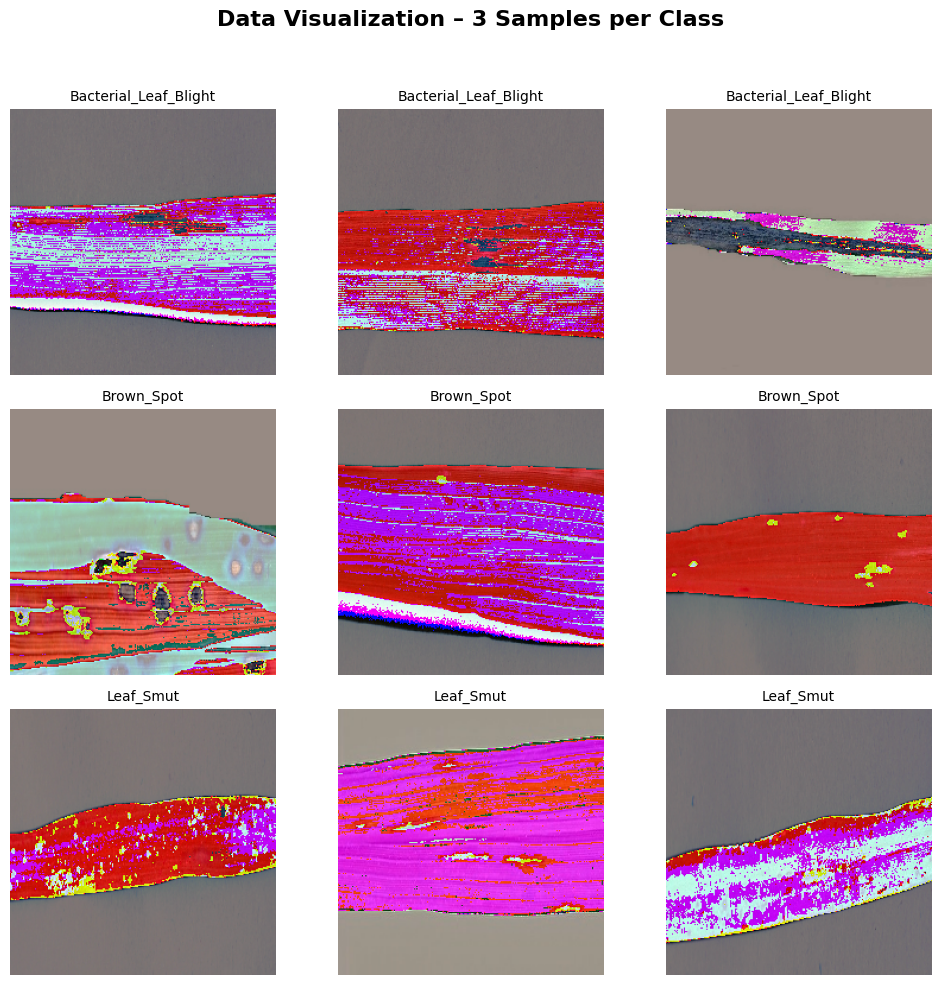

In [7]:
if 'train_ds' not in locals() and 'train_ds' not in globals():
    print("Error: train_ds is not defined. Please run the previous cell to load and preprocess the data.")
else:
    for images, labels in train_ds.take(1):
        print("Image batch shape:", images.shape)
        print("Label batch shape:", labels.shape)
    print('\n')

    # Map class indices back to names
    index_to_label = {v: k for k, v in label_to_index.items()}

    # Collect 3 images per class
    samples_per_class = {label: [] for label in range(len(class_names))}

    for images, labels in train_ds.unbatch():
        label_idx = tf.argmax(labels).numpy()
        if len(samples_per_class[label_idx]) < 3:
            samples_per_class[label_idx].append(images)
        if all(len(v) == 3 for v in samples_per_class.values()):
            break  # Stop once we have 3 per class

    # Flatten into a single list of (image, label)
    sample_images = []
    sample_labels = []
    for label_idx, imgs in samples_per_class.items():
        for img in imgs:
            sample_images.append(img)
            sample_labels.append(index_to_label[label_idx])

    # Plot 3×3 grid with title
    plt.figure(figsize=(10, 10))
    plt.suptitle("Data Visualization – 3 Samples per Class", fontsize=16, fontweight='bold')

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(sample_images[i], tf.uint8))  # Cast to uint8 for display
        plt.title(sample_labels[i], fontsize=10)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()
    print('\n')

#Model Definition

In [8]:
# Device Setup
gpus = tf.config.list_physical_devices('GPU')
device = '/GPU:0' if gpus else '/CPU:0'
print(f"Using device: {device}")
print('\n')

# Enable device placement logging
tf.debugging.set_log_device_placement(True)

# Load pretrained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Transfer Learning Using MobileNetV2
with tf.device(device):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

Using device: /GPU:0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Model Training and Validation


In [9]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.1)
    ]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3889 - loss: 13.3101

3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.3958 - loss: 15.7104 - val_accuracy: 0.5000 - val_loss: 48.4895 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6285 - loss: 34.3138

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.6302 - loss: 33.1476 - val_accuracy: 0.5000 - val_loss: 15.0379 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.7565 - loss: 9.0639 - val_accuracy: 0.5000 - val_loss: 32.4558 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6615 - loss: 15.2288

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step - accuracy: 0.6758 - loss: 14.5505 - val_accuracy: 0.5833 - val_loss: 12.8204 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.8398 - loss: 6.4191 - val_accuracy: 0.6667 - val_loss: 13.0007 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9236 - loss: 2.2501

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step - accuracy: 0.9167 - loss: 2.5284 - val_accuracy: 0.6667 - val_loss: 12.1856 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9271 - loss: 2.3076

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9219 - loss: 2.5344 - val_accuracy: 0.7500 - val_loss: 3.7733 - learning_rate: 0.0010
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9844 - loss: 0.3252

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9805 - loss: 0.3910 - val_accuracy: 0.7500 - val_loss: 2.4733 - learning_rate: 0.0010
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.9896 - loss: 0.1655 - val_accuracy: 0.6667 - val_loss: 5.6694 - learning_rate: 0.0010
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.9635 - loss: 0.6577 - val_accuracy: 0.6667 - val_loss: 6.4430 - learning_rate: 0.0010
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.9909 - loss: 0.0648 - val_accuracy: 0.5833 - val_loss: 4.8801 - learning_rate: 0.0010
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9722 - loss: 0.1555

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.9740 - loss: 0.1586 - val_accuracy: 0.7500 - val_loss: 1.8723 - learning_rate: 0.0010
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 1.0000 - loss: 0.0085

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9167 - val_loss: 0.9003 - learning_rate: 0.0010
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 1.0000 - loss: 0.0025

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9167 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9913 - loss: 0.0092

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9909 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9931 - loss: 0.1433

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 838ms/step - accuracy: 0.9896 - loss: 0.2138 - val_accuracy: 1.0000 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 17/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.9831 - loss: 0.0737 - val_accuracy: 0.9167 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 18/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 19/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.9948 - loss: 0.0305 - val_accuracy: 0.9167 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 20/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 1.0000 - loss: 7.7826e-04 - val_accuracy: 0.9167 - val_loss: 1.1944 - learning_rate: 0.0010
Epoch 21/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 1.0000 - loss: 1.1952e-08 - val_accuracy: 0.9167 - val_loss: 1.4789 - learning_rate: 0.0010
Epoch 22/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 1.0000 - loss: 0.0026 - val_acc

#Loss and Accuracy curve

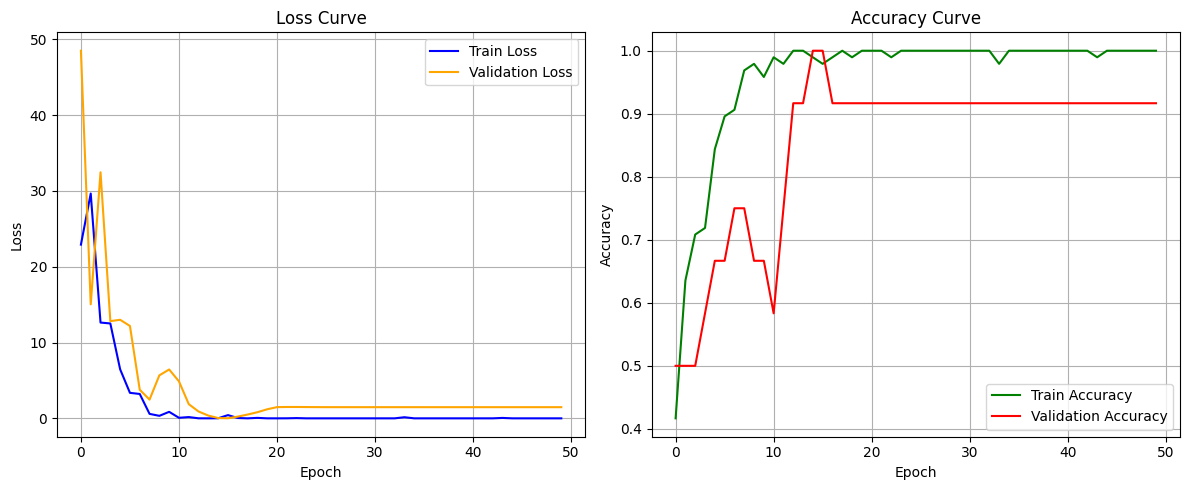

In [10]:
# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Curve
ax1.plot(history.history["loss"], label="Train Loss", color='blue')
ax1.plot(history.history["val_loss"], label="Validation Loss", color='orange')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy Curve
ax2.plot(history.history["accuracy"], label="Train Accuracy", color='green')
ax2.plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#Confusion Matrix Display

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


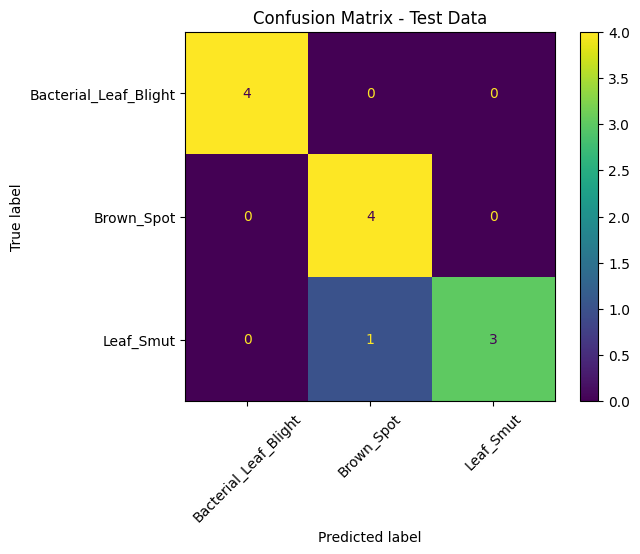

                       precision    recall  f1-score   support

Bacterial_Leaf_Blight       1.00      1.00      1.00         4
           Brown_Spot       0.80      1.00      0.89         4
            Leaf_Smut       1.00      0.75      0.86         4

             accuracy                           0.92        12
            macro avg       0.93      0.92      0.92        12
         weighted avg       0.93      0.92      0.92        12



In [11]:
# Get predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # assuming one-hot labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Test Data")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))